In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import hypergeom

import os
os.makedirs('Figure_3', exist_ok=True)




# FIGURE 3
### Cell-specific gene expression is associated with cortical morphology at birth
Make sure results from `B__run_gene_models.py` and  `D__cell_enrichments.py` ara available

In [43]:
def safe_div(x,y):
    if y == 0:
        return np.array([0])
    return x / y


def calculate_enrichment(hit_list, top_genes, full_gene_list):
    x = sum(pd.DataFrame(top_genes).isin(hit_list).values) # how many top genes in cell list
    n = sum(pd.DataFrame(hit_list).isin(full_gene_list).values)[0] # how many cell genes in full list
    N = len(top_genes)  # number of samples
    M = len(full_gene_list)  # total number in population

    enrichment = safe_div( (x/N) , ((n-x) / (M-N)) )
    p = hypergeom.sf(x-1, M, n, N)

    return enrichment, p


cell_colours = sns.color_palette([(0.65, 0.46, 0.11),
                                  (0.10, 0.62, 0.46),
                                  (0.91, 0.16, 0.54),
                                  (0.21, 0.22, 0.23),
                                  (0.45, 0.44, 0.70),
                                  (0.85, 0.37, 0.01),
                                  (0.40, 0.40, 0.40),
                                  (0.31, 0.32, 0.33),
                                  (0.40, 0.65, 0.12),
                                  (0.90, 0.67, 0.01),
                                  (0.40, 0.30, 0.21)])

cell classes


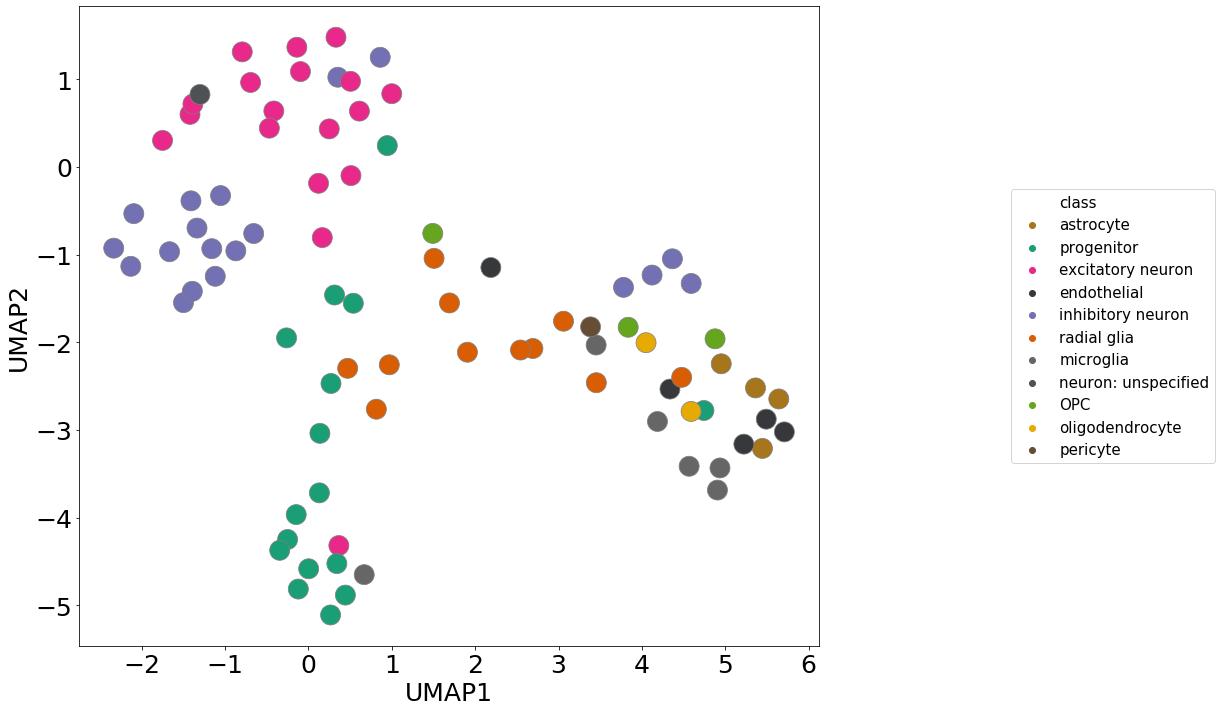

In [44]:
# Figure 3A - UMAP embeddings
# load UMAP embeddings
embedded_data = pd.read_csv('../data/umap/cell-specific-embedding.csv')

# change names to something better
cell_name_dict = {'neuron_excitatory':'excitatory neuron',
                  'neuron_inhibitory':'inhibitory neuron',
                  'radial_glia':'radial glia',
                  'neuron':'neuron: unspecified'}
embedded_data['class'] = embedded_data['class'].map(cell_name_dict).fillna(embedded_data['class'])

# plot coloured by cell class
print('cell classes')
fig, ax = plt.subplots(1,1,figsize=(18,10))
sns.scatterplot('umap1', 'umap2', hue='class', data=embedded_data, s=400, palette=cell_colours, edgecolor='grey', ax=ax)
plt.legend(fontsize=15, loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
ax.set_xlabel('UMAP1', fontsize=25)
ax.set_ylabel('UMAP2', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)

plt.tight_layout()
plt.savefig('Figure_3/Figure3A.png')


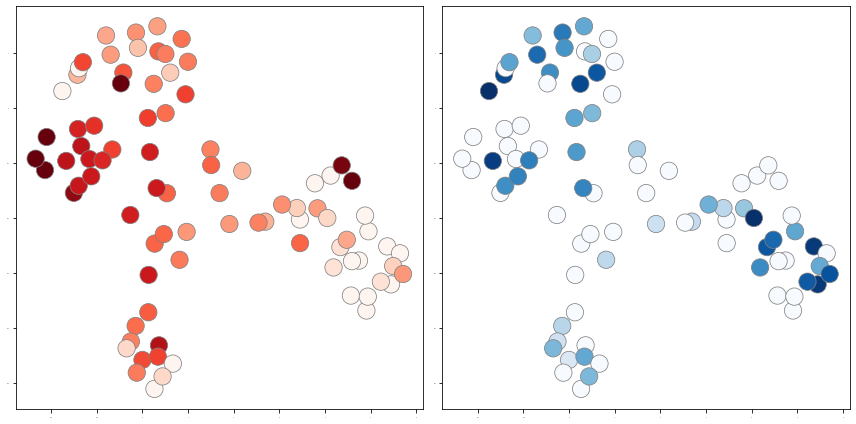

In [45]:
# calculate enrichment of each cell type in positive and negative genes
all_gene_data = pd.read_csv('../data/gene_lists/all-scRNA-data.csv')
background_genes = pd.read_csv('../data/gene_lists/all_genes.txt', header=None)[0]

# get list of significant genes
significant_genes = pd.read_csv('../results/gene_correlations/PCA_correlations-KendallTau-PC-significant_genes-p0.05.csv')

for sign in ['positive', 'negative']:
    types =  []
    overlaps = []
    if sign == 'positive':
        gene_list = significant_genes.loc[significant_genes['PC1_tau']>0,'symbol']
    else:
        gene_list = significant_genes.loc[significant_genes['PC1_tau']<0,'symbol']

    for cell_type in np.unique(embedded_data['cluster_study']):
        # all genes in cell class
        cell_type_gene_list = np.unique(all_gene_data.loc[all_gene_data['cluster_study']==cell_type,'gene'])

        overlap = calculate_enrichment(list(cell_type_gene_list), list(gene_list), list(background_genes))[0]
        types.append(cell_type)
        overlaps.append(overlap)

    overlap_dict = dict(zip(np.hstack(types), np.hstack(overlaps)))
    embedded_data[sign + '_overlap'] = embedded_data['cluster_study'].map(overlap_dict)

fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.scatterplot(embedded_data['umap1'].values, embedded_data['umap2'].values, hue=np.log(embedded_data['positive_overlap'].values+1),
            s=300, palette='Reds', edgecolor='grey', legend=False, hue_norm=(0.35,3.5), ax=ax[0])
ax[0].set_xlabel('', fontsize=20)
ax[0].set_ylabel('', fontsize=20)
ax[0].tick_params(axis='both', which='major', labelsize=0)

sns.scatterplot(embedded_data['umap1'].values, embedded_data['umap2'].values, hue=np.log(embedded_data['negative_overlap'].values+1),
            s=300, palette='Blues', edgecolor='grey', legend=False, hue_norm=(0.25,2), ax=ax[1])
ax[1].set_xlabel('', fontsize=20)
ax[1].set_ylabel('', fontsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=0)

plt.tight_layout()
plt.savefig('Figure_3/Figure3A-inset.png')

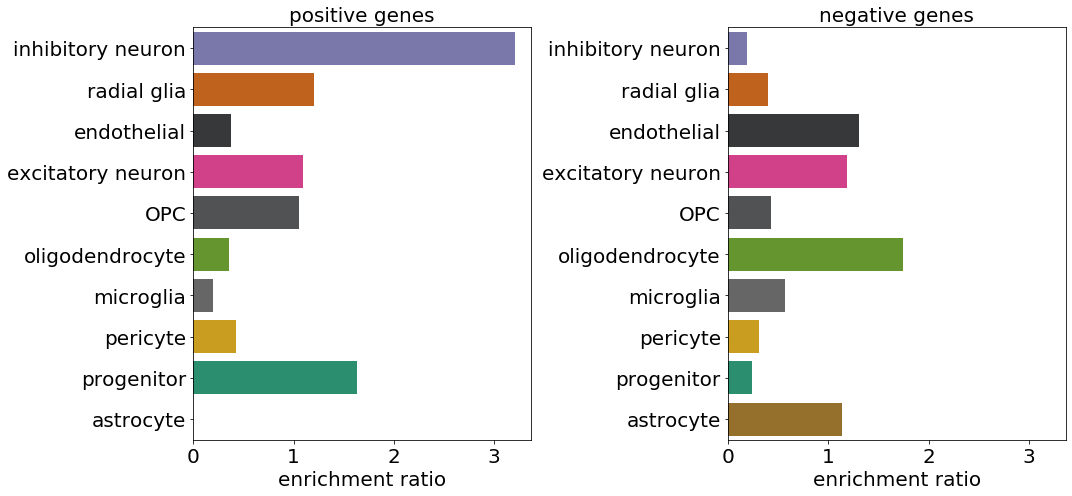

In [46]:
# Figure 3B
enrichment = pd.read_csv('../results/enrichment/cell_class_enrichment-PC1-significant_genes-p0.05.csv')

# better names for some classes
cell_name_dict = {'neuron_excitatory':'excitatory neuron',
                  'neuron_inhibitory':'inhibitory neuron',
                  'radial_glia':'radial glia',
                  'neuron':'neuron: unspecified'}

# positive and negative cell enrichments
positive_enrichment = enrichment.loc[enrichment.loading=='positive']
positive_enrichment = positive_enrichment[positive_enrichment.gene_list=='all'].copy()
positive_enrichment['class'] = positive_enrichment['class'].map(cell_name_dict).fillna(positive_enrichment['class'])

negative_enrichment = enrichment.loc[enrichment.loading=='negative']
negative_enrichment = negative_enrichment[negative_enrichment.gene_list=='all'].copy()
negative_enrichment['class'] = negative_enrichment['class'].map(cell_name_dict).fillna(negative_enrichment['class'])

# set order for plot (hue order to match UMAP plot)
col_order = ['inhibitory neuron', 'radial glia', 'endothelial', 'excitatory neuron', 'OPC', 'oligodendrocyte', 'microglia', 'pericyte', 'progenitor', 'astrocyte']
order = ['astrocyte', 'progenitor', 'excitatory neuron', 'endothelial', 'inhibitory neuron', 'radial glia', 'microglia', 'OPC', 'oligodendrocyte', 'pericyte']

# plot enrichments
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7), sharey=False, sharex=True)
sns.barplot(y='class', x='enrichment', hue='class', order=col_order, hue_order=order, palette=cell_colours, data=positive_enrichment,
            dodge=False, ax=ax1, orient='h')

sns.barplot(y='class', x='enrichment', hue='class',  order=col_order, hue_order=order, palette=cell_colours, data=negative_enrichment,
            dodge=False, ax=ax2, orient='h')

for ax in [ax1,ax2]:
    ax.legend().set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_ylabel('')
    ax.set_xlabel('enrichment ratio', fontsize=20)
ax1.set_title('positive genes', fontsize=20)
ax2.set_title('negative genes', fontsize=20)

plt.tight_layout()
plt.savefig('Figure_3/Figure_3B.png')
